*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

In [80]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly_express as px
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [81]:
# Import data
dataset = pd.read_csv(r'insurance.csv')
dataset.tail()

,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [82]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [83]:
dataset.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [84]:
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.00,27.0000,39.00,51.000,64.00
bmi,1338.0,30.665471,6.098382,16.00,26.3000,30.40,34.700,53.10
children,1338.0,1.094918,1.205493,0.00,0.0000,1.00,2.000,5.00
expenses,1338.0,13270.422414,12110.011240,1121.87,4740.2875,9382.03,16639.915,63770.43


# Let's visualize our data:

<AxesSubplot:xlabel='sex', ylabel='expenses'>

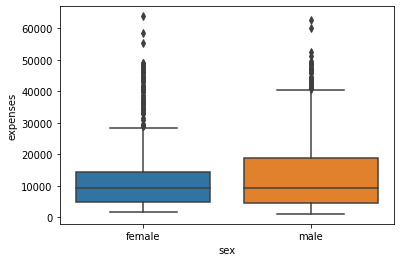

In [85]:
sns.boxplot(data=dataset, x='sex', y='expenses')

In [86]:
dataset[dataset['sex'] == 'female']['expenses'].describe()

count      662.000000
mean     12569.578897
std      11128.703817
min       1607.510000
25%       4885.162500
50%       9412.965000
75%      14454.690000
max      63770.430000
Name: expenses, dtype: float64

In [87]:
dataset[dataset['sex'] == 'male']['expenses'].describe()

count      676.000000
mean     13956.751420
std      12971.025897
min       1121.870000
25%       4619.135000
50%       9369.615000
75%      18989.595000
max      62592.870000
Name: expenses, dtype: float64

Seems like insurance expenses don't correlate too well with a person's sex, although the IQR and whiskers for the male sex are larger than females'.

Let's check out whether the same holds true for a person's smoking habits:

Text(-0.3, 10000, 'average expense for non-smokers')

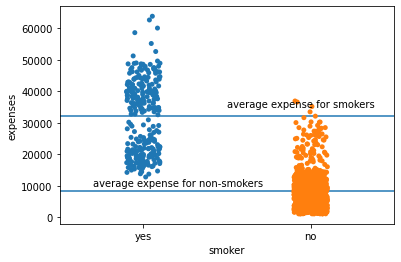

In [88]:
fig = sns.stripplot(data=dataset, x='smoker', y='expenses')
fig.axhline(dataset[dataset['smoker'] == 'yes'].expenses.mean())
fig.axhline(dataset[dataset['smoker'] == 'no'].expenses.mean())
fig.text(0.5, 35000, 'average expense for smokers')
fig.text(-0.30, 10000, 'average expense for non-smokers')

As intuition would dictate, smokers end up paying more on average than non-smokers.

Let's see how much insurance costs across different regions:

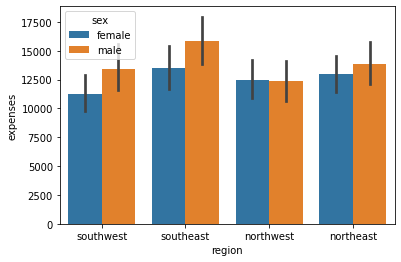

In [89]:
fig = sns.barplot(data=dataset, x='region', y='expenses', hue='sex')

In [90]:
dataset.groupby('region')['expenses'].describe()

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
northeast,324.0,13406.384691,11255.802916,1694.80,5194.3225,10057.655,16687.3650,58571.07
northwest,325.0,12417.575169,11072.276880,1621.34,4719.7400,8965.800,14711.7400,60021.40
southeast,364.0,14735.411538,13971.098797,1121.87,4440.8850,9294.130,19526.2875,63770.43
southwest,325.0,12346.937908,11557.179033,1241.57,4751.0700,8798.590,13462.5200,52590.83


Although the average cost of insurance does not vary all that much from region to region, it appears as though males pay more for insurance than females in the southwestern and southeastern regions.

Finally, let's have a look at how much a person's BMI (Body mass index) affects the price of their insurance:

In [91]:
px.histogram(data_frame=dataset, x='bmi', y='expenses', color='sex')

We can see from the plot above that a high BMI does not necessarily indicate a higher priced insurance plan e.g. the group that paid the most for insurance consisted of males with a BMI between 30.5 - 31.4

It's also worth noting that we have an almost normal distribution, just slightly skewed to the left.

# Preprocessing our dataset:

In [92]:
y = dataset.pop('expenses')

In [93]:
dataset['smoker'].replace({
    'no' : 0,
    'yes' : 1  
}, inplace=True)

dataset['sex'].replace({
    'female' : 0,
    'male' : 1
}, inplace=True)

In [94]:
categorical_cols = ['sex', 'smoker', 'region']
num_cols = list(set(dataset.columns) - set(categorical_cols))

In [95]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(dataset['region'])
dataset['region'] = encoder.transform(dataset['region'])

In [96]:
dataset.head()

,age,sex,bmi,children,smoker,region
0,19,0,27.9,0,1,3
1,18,1,33.8,1,0,2
2,28,1,33.0,3,0,2
3,33,1,22.7,0,0,1
4,32,1,28.9,0,0,1


In [97]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset, y, train_size=0.8)

# Let's make a model using neural networks:

In [141]:
# We create a normalization layer in order to scale values to a similar range:
normalizer = keras.layers.Normalization()
normalizer.adapt(np.array(X_train))

model = keras.Sequential([
    normalizer,
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(1, activation='linear')
])

In [142]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mae', optimizer=optimizer, metrics=['mse','mae'])

In [143]:
model.build()

## And here's what our model looks like:
We also added a dropout layer in order to prevent overfitting.

In [144]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_8 (Normalizat  (None, 6)                13        
 ion)                                                            
                                                                 
 dense_31 (Dense)            (None, 32)                224       
                                                                 
 dense_32 (Dense)            (None, 16)                528       
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_33 (Dense)            (None, 1)                 17        
                                                                 
Total params: 782
Trainable params: 769
Non-trainable params: 13
______________________________________________________

In [145]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_split=0.2)

Epoch 1/100
27/27 [==============================] - 0s 5ms/step - loss: 13317.0215 - mse: 323379232.0000 - mae: 13317.0215 - val_loss: 14090.5469 - val_mse: 359009504.0000 - val_mae: 14090.5469
Epoch 2/100
27/27 [==============================] - 0s 2ms/step - loss: 13262.8018 - mse: 321888032.0000 - mae: 13262.8018 - val_loss: 13973.3398 - val_mse: 355663040.0000 - val_mae: 13973.3398
Epoch 3/100
27/27 [==============================] - 0s 2ms/step - loss: 13022.4307 - mse: 315630976.0000 - mae: 13022.4307 - val_loss: 13571.3145 - val_mse: 344992352.0000 - val_mae: 13571.3145
Epoch 4/100
27/27 [==============================] - 0s 2ms/step - loss: 12367.8906 - mse: 299531232.0000 - mae: 12367.8906 - val_loss: 12655.0176 - val_mse: 321818944.0000 - val_mae: 12655.0176
Epoch 5/100
27/27 [==============================] - 0s 2ms/step - loss: 11250.3496 - mse: 271352416.0000 - mae: 11250.3496 - val_loss: 11325.8613 - val_mse: 282973312.0000 - val_mae: 11325.8613
Epoch 6/100
27/27 [======

# Evaluating the model:

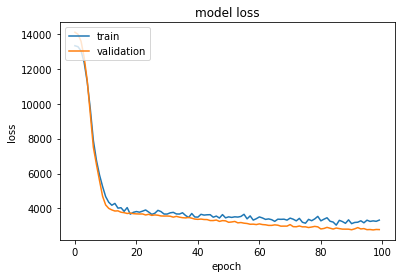

In [170]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [146]:
pred = model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 732us/step - loss: 2627.6802 - mse: 31966712.0000 - mae: 2627.6802


We end up with a Mean Absolute Error of 2627. Not bad! 

### Toying around with predictions a bit

In [158]:
predictions = model.predict(X_test)
print(predictions[7])
print(y_test[7])

9/9 [==============================] - 0s 488us/step
[25842.828]
[24667.42]


In [167]:
me = {
    'age' : 22,
    'sex' : 0,
    'bmi' : 20.6,
    'children' : 0,
    'smoker' : 0,
    'region' : 1
}

sample = pd.DataFrame(me, index=[0])

In [168]:
print(sample)

   age  sex   bmi  children  smoker  region
0   22    0  20.6         0       0       1


In [169]:
print(model.predict(sample))

1/1 [==============================] - 0s 17ms/step
[[2773.8228]]


In [ ]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
